## 11.4 高维向量可视化
在第6章迁移学习一节介绍中过，在ImageNet上训练好的卷积神经网络模型的卷积层可以被看成是对图片进行特征提取的过程，那么这个特征提取结果的效果在没有可视化的情况下是不容易被直观判断的。类似地，第9章中介绍的单词向量也很难直观地了解其效果。

**为了更加直观的让大家了解这类embedding向量的效果， TensorBoard提供了PROJECTOR界面来可视化高维向量之间的关系。**PROJECTOR界面可以非常方便地可视化多个高维向量之间的关系。比如在图像迁移学习中可以将一组目标问题的图片通过训练好的卷积层得到瓶颈层，这些瓶颈层向量就是多个高维向量。如果在目标问题图像数据集上同一种类的图片在经过卷积层之后得到的瓶颈层向量在空间中比较接近，那么这样迁移学习得到的结果就有可能会更好。类似地，在训练单词向量时，如果语义相近的单词所对应的向量在空间中的距离也比较接近的话，那么自然语言模型的效果也有可能会更好。

为了更直观地介绍TensorBoard PROJECTOR的使用方法，本节将给出一个MNIST的样例程序。这个样例程序在MNIST数据上训练了一个简单的全连接神经网络。本节将展示在训练100轮和10000轮之后，测试数据经过整个神经网络得到的输出层向量通过PROJECTOR得到的可视化结果。**为了在PROJECTOR中更好地展示MNIST图片信息以及每张图片对应的真实标签，PROJECTOR要求用户准备一个sprite图像和一个tsv文件给出每张图片对应的标签信**。以下代码给出了如何使用MNIST测试数据生成PROJECTOR所需要的这两个文件。

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


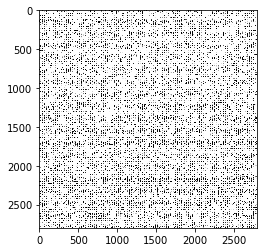

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data

# PROJECTOR需要的日志文件名和地址相关参数
LOG_DIR = 'log/high_dim'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"

# 使用给出的MNIST图片列表生成sprite图像
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    # sprite图像可以理解成是所有小图片拼成的大正方形矩阵，大正方形矩阵中的每一个
    # 元素就是原来的小图片。于是这个正方形的地长就是sqrt(n)，其中n为小图片的数量。
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    # 使用全1来初始化最终的大图片
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            # 计算当前图片的编号
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                # 将当前小图片的内容复制到最终的sprite图像
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

# 加载MNIST数据，这列onehot为False，得到的labels为数字
mnist = input_data.read_data_sets("../../datasets/MNIST_data", one_hot=False)

# 生成sprite图像
to_visualise = 1 - np.reshape(mnist.test.images,(-1,28,28))
sprite_image = create_sprite_image(to_visualise)

# 将生成的sprite图像放到相应的日志目录下
path_for_mnist_sprites = os.path.join(LOG_DIR, SPRITE_FILE)
plt.imsave(path_for_mnist_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

# 生成每张图片对应的标签文件并写到相应的日志目录下。
path_for_mnist_metadata = os.path.join(LOG_DIR, META_FIEL)
with open(path_for_mnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(mnist.test.labels):
        f.write("%d\t%d\n" % (index,label))

运行以上代码可以得到两个文件， 一个是如图11.22所示的MNIST测试数据sprite图像，这个图像包含了所有的MNIST测试数据图像。另一个是mnist_meta.tsv，下面给出了这个tsv文件的前面几行。可以看出，这个文件的第一行是每一列的说明，以后的每一行代表一张图片，在这个文件中给出了每一张图对应的真实标签。

| Index| Label |
|:----:|:-----:|
|   0 |   7  |
|   1 |   2  |
|   2 |   1  |
|   3 |   0  |
|   4 |   4  |

<p align='center'>
    <img src=images/mnist_sprite.jpg>
    <center>图11-22 使用MNIST测试数据集生成的sprite图像
</p>

在生成好辅助数据之后，以下代码展示了如何使用TensorFlow代码生成PROJECTOR所需要的日志文件来可视化MNIST测试数据在最后的输出层向量。

In [2]:
import tensorflow as tf
import mnist_inference
import os

# 加载用于生成PROJECTOR日志的帮助函数。
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

# 和第5章中类似地定义训练模型需要的参数。这里我们同样是复用第5章中定义的
# mnist_inference过程。
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 10000
MOVING_AVERAGE_DECAY = 0.99

LOG_DIR = 'log/high_dim'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"
TENSOR_NAME = "FINAL_LOGITS"

# 训练过程和第5章给出来的基本一致，唯一不同的是这里还需要返回最后测试数据经过整个
# 神经网络得到的输出层矩阵（因为有多张测试图片，每张图片对应了一个输出层向量，所以
# 返回的结果是这些向量组成的矩阵〉。
def train(mnist):
    #  输入数据的命名空间。
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    y = mnist_inference.inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)
    
    # 处理滑动平均的命名空间。
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
   
    # 计算损失函数的命名空间。
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    
    # 定义学习率、优化方法及每一轮执行训练的操作的命名空间。
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            mnist.train.num_examples / BATCH_SIZE, LEARNING_RATE_DECAY,
            staircase=True)

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        with tf.control_dependencies([train_step, variables_averages_op]):
            train_op = tf.no_op(name='train')
    
    # 训练模型。
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: xs, y_: ys})
                
            if i % 1000 == 0:
                print("After %d training step(s), loss on training batch is %g." % (i, loss_value))
        
        # 计算MNIST测试数据对应的输出层矩阵。
        final_result = sess.run(y, feed_dict={x: mnist.test.images})
    
    # 返回输出层矩阵的值
    return final_result


# 生成可视化最终输出层向量所需要的日志文件。
def visualisation(final_result):
    # 使用一个新的变量来保存最终输出层向量的结果。因为embedding是通过TensorFlow
    # 中变量完成的，所以PROJECTOR可视化的都是TensorFlow中的变量。于是这里要
    # 新定义一个变量来保存输出层向量的取值。
    y = tf.Variable(final_result, name=TENSOR_NAME)
    summary_writer = tf.summary.FileWriter(LOG_DIR)

    # 通过projector.ProjectorConfig类来帮助生成日志文件。
    config = projector.ProjectorConfig()
    # 增加一个需要可视化的embedding结果
    embedding = config.embeddings.add()
    # 指定这个embedding结果对应的TensorFlow变量名称
    embedding.tensor_name = y.name

    # 指定embedding结果所对应的原始数据信息。比如这里指定的就是每一张MNIST测试
    # 图片对应的真实类别。在单词向量中可以是单词ID对应的单词。这个文件是可选的，
    # 如果没有指定那么向量就没有标签。
    embedding.metadata_path = META_FIEL

    # 指定sprite图像。这个也是可选的，如果没有提供sprite图像，那么可视化的结果
    # 每一个点就是一个小圆点，而不是具体的图片。
    embedding.sprite.image_path = SPRITE_FILE
    # 在提供sprite图像时，通过single_image_dim可以指定单张图片的大小。
    # 这将用于从sprite图像中截取正确的原始图片。
    embedding.sprite.single_image_dim.extend([28,28])

    # 将PROJECTOR所需要的内容写入日志文件。
    projector.visualize_embeddings(summary_writer, config)
    
    # 生成会话，初始化新声明的变量并将需要的日志信息写入文件。
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR, "model"), TRAINING_STEPS)
    
    summary_writer.close()
    

# 主函数
def main(argv=None): 
    mnist = input_data.read_data_sets("../../datasets/MNIST_data", one_hot=True)
    final_result = train(mnist)
    visualisation(final_result)

if __name__ == '__main__':
    main()

Extracting ../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
After 0 training step(s), loss on training batch is 2.99054.
After 1000 training step(s), loss on training batch is 0.183446.
After 2000 training step(s), loss on training batch is 0.146804.
After 3000 training step(s), loss on training batch is 0.14023.
After 4000 training step(s), loss on training batch is 0.116306.
After 5000 training step(s), loss on training batch is 0.104121.
After 6000 training step(s), loss on training batch is 0.0938725.
After 7000 training step(s), loss on training batch is 0.0926095.
After 8000 training step(s), loss on training batch is 0.0888463.
After 9000 training step(s), loss on training batch is 0.0814582.


*注意这一部分书上版本略有落后，可参考[projector官网](https://projector.tensorflow.org)，另外小图片一直操作不出来，待改进*

运行以上代码就可以得到PROJECTOR所需要的所有日志文件。在LOGDIR下启动TensorBoard就可以看到类似图11.23所示的效果图。从图11.23(a)中可以看出，在17轮迭代之后，模型的分类效果不是很理想，所以图11.23(a)上不同颜色的图片（代表不同的类别）混乱地挤在一起。但是当迭代100轮之后从图11.23(b)上可以明显地看出不同颜色的图片的区分度还是比较大的。
<p align='center'>
    <img src=images/图11.23a.JPG>
    <center>(a) 使用5.5节给出的网络结构在训练17轮之后的结果</center>
    <img src=images/图11.23b.JPG>
    <center>(b) 使用5.5节给出的网络结构在训练100轮之后的结果</center>
    <center>图11-23 使用T-SNE可视化得到的MNIST测试数据在最后输出层的向量</center>
</p>

在**PROJECTOR界面的左上角是数据面板，**有若干个选项：
- 第一个“FINAL_LOGITS”选项是选择需要可视化的Tensor，这里默认选择的是通过ProjectorConfig中指定的tensor_name，也就是名为FINAL_LOGITS的张量。点开这个选项可以看到其他可以可视化结果，虽然PROJECTOR也可以可视化这些向量，但是在这个场景下意义不大；
- 第二个“Label by”选项可以控制当鼠标移到一个向量上时鼠标附近显示的标签。比如这里选定的是“Index”，那么当鼠标移到某个点上之后显示的就是这个点对应的编号。
- 第三个“Color by”选项可以指定每一个小图片的背景颜色。图11.23中小图片的背景颜色都是根据标签选取的，所以拥有相同标签的样例的背景颜色是一样的。这样可以快速区分哪些样例属于同一个种类。
- 第四个是“Suprevised with”，最后一个是“Edit by”，这两个功能还有待摸索。

在**PROJECTOR界面的左下角是投影面板，**提供了不同的高维向量的可视化方法，目前主要支持的就是T-SNE和PCA。无论是T-SNE还是PCA都可以将一个高维向量转化成一个低维向量，并尽量保证转化后向量中的信息不受影响。因为篇幅的关系本书中不再详细介绍这些具体的算法。

在**PROJECTOR界面的右上角是检查工具面板，**提供了高亮功能。图展示了搜索所有代表数字3的图片，可以看出所有代表数字3的图片都被高亮标出来了，而且大部分的图片都集中在一个比较小的区域，只有少数离中心区域比较远。通过这种方式可以很快地找到每个类别中比较难分的图片，加速错误案例分析的过程。
<p align='center'>
    <img src=images/图11.26.JPG>
    <center>图11-26 PROJECTOR界面的搜索高亮功能</center>
</p>

在**PROJECTOR界面的右下角**提供了分享功能，可以将当前状态保存为小文件的功能，接着可以将PROJECTOR指向一个包含一个或多个这些文件的集合，方便其他用户查看一系列书签。